<span style="color:green">Welcome to Jake's Python Data Exploration: Stock Market and Inflation</span> 

In 2022, inflation impacted the stock market performance in an abnormal behavior as the Fed continued to raise interest rates. This exploration aims to investigate the correlation between inflation-related economic factors and the stock market during a rising rate environment. By examining historical data, we can gain insight into potential future market trends. Since 1990, there have been four rate hiking cycles, each lasting an average of 18 months: June 1999 to June 2000, June 2004 to June 2006, December 2015 to December 2018, and March 2022 to the present. (to find out more about how I derived at these time periods and relationship between stock market and interest rates, please check out my Tableau Data Exploration: https://public.tableau.com/views/Capstone1_16607092350810/Story1?:language=en-US&:display_count=n&:origin=viz_share_link).

I will be focusing on relationship between stock market (S&P 500) and following economical variables:

**Core CPI** - Core CPI is a measurement of inflation excluding more volatile categoires, food and energy. As the Fed looks primarily at 'core' prices, rise in core CPI seem to have negatively impacted the stock market as rise in core CPI can lead to the Fed increasing rates. 

**WTI Crude Oil** - oil prices have sky-rocketted in 2022 mainly due to the Russia-Ukraine war that impacted the oil supplies.
Rise in oil prices seem to negatively impact stock market as it leads to rise in inflation and fed increasing rates. 

**Average Hourly Earnings** - Government releases average hourly earnings numbers on first Friday of every month when jobs report comes out. Average hourly earnings can help estimate coming inflation. 

**Unemployment** - Rising unemployment rates can indicate a weak economy, which usually negatively impact the stock market. However, towards the end of 2022, most of the investors were hoping for higher unemployment in hopes for the Fed to stop or slow down on raising interest rates with rising unemployment. 

**US Dollar Index** - US dollar strengthened against most of the major currency as the Fed aggressively hiked interest rates in 2022. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#Download Dataset - the following six data sets will be used in this exploration. I will download them in order.
#1. S&P 500 closing price (Source:https://www.wsj.com/market-data/quotes/index/SPX/historical-prices)
#2. CPI (Core Inflation)
#3. WTI crude oil
#4. Avg Hourly Earnings
#5. Unemployment
#6. US Dollar Index

In [3]:
df_sp500 = pd.read_csv("SP500.csv", index_col="Date")
df_cpi = pd.read_csv("CPI.csv", index_col="Date")
df_wti_co = pd.read_csv("WTI_Crude_Oil.csv", index_col="Date")
df_avg_hrly_earnings = pd.read_csv("Avg_Hourly_Earnings.csv", index_col="Date")
df_unemployment = pd.read_csv("unemployment.csv", index_col="Date")
df_usd = pd.read_csv("USD.csv", index_col="Date")

In [4]:
#Dataset
print(df_sp500.head())
print(df_cpi.head())
print(df_wti_co.head())
print(df_avg_hrly_earnings.head())
print(df_unemployment.head())
print(df_usd.head())

           Close
Date            
1/3/1989  275.31
1/4/1989  279.43
1/5/1989  280.01
1/6/1989  280.67
1/9/1989  280.98
          USACPICORMINMEI
Date                     
1/1/1960        12.590481
2/1/1960        12.631761
3/1/1960        12.631761
4/1/1960        12.631761
5/1/1960        12.631761
          DCOILWTICO
Date                
1/2/1986       25.56
1/3/1986       26.00
1/6/1986       26.53
1/7/1986       25.85
1/8/1986       25.87
          Avg Hourly Earnings
Date                         
3/1/2006                20.04
4/1/2006                20.16
5/1/2006                20.13
6/1/2006                20.22
7/1/2006                20.30
          Value
Date           
1/1/1990    5.4
2/1/1990    5.3
3/1/1990    5.2
4/1/1990    5.4
5/1/1990    5.4
            Price
Date             
12/27/1989  92.66
12/28/1989  93.27
12/29/1989  93.21
1/1/1990    93.21
1/2/1990    94.29


**Interpret Dataset** 

Looking at the datasets, we can notice that frequency of each datasets are different. For example, CPI, average hourly earning and unemployment numbers are released monthly and only have values once a month. On the other hand, S&P 500, WTI Crude Oil price and US Dollar numbers are daily values(except for weekends and holidays). Thus, we will have to adjust daily values into monthly values. We can simply use left-join function and match 1st of every month number for S&P 500, however, one day value is not a good representation of entire month since market fluctuates alot. So I decided to use rolling 30-days average closing price instead of using 1st of every month value for S&P 500 closing values. 

Also, CPI is a measure of average change over time in the prices that cosumers pay for goods and services throughout the US economy. As CPI will only show a gradual increase over the time, we will covert it to a rate of change. CPI is usually converted to a rate of change since the most common inflation metric is the percent change from one year ago. 

In [5]:
#Calculating 30-days moving average of S&P 500 closing price
df_sp500['sp500r30'] = df_sp500.rolling(window=30).mean()
print(df_sp500.tail())  #using .tail instead of .head since first 30 numbers will come out as NaN

#CPI monthly change
df_cpi_monthly = df_cpi / df_cpi.shift(12) * 100 - 100
df_cpi_monthly.tail()  #using .tail instead of .head since first 12 numbers will return NaN

             Close     sp500r30
Date                           
1/5/2023   3808.10  3923.461667
1/6/2023   3895.08  3919.845000
1/9/2023   3892.09  3915.339333
1/10/2023  3919.25  3911.777000
1/11/2023  3969.61  3911.966000


,USACPICORMINMEI
Date,
1/1/2022,6.020648
2/1/2022,6.414206
3/1/2022,6.474479
4/1/2022,6.160574
5/1/2022,6.021537


In [6]:
#Merge Dataset
df = pd.merge(df_cpi_monthly, df_sp500['sp500r30'], on='Date', how='left')
df = pd.merge(df, df_wti_co, on='Date', how='left')
df = pd.merge(df, df_unemployment, on='Date', how='left')
df = pd.merge(df, df_usd, on='Date', how='left')
df = df.rename(columns={'USACPICORMINMEI': 'CPI', 'DCOILWTICO': 'WTICO', 'Value': 'Unemployment', 'Price': 'USD'})
df.tail() #using .tail instead of .head since CPI and SP500 will return NaN for first 12 numbers

,CPI,sp500r30,WTICO,Unemployment,USD
Date,,,,,
1/1/2022,6.020648,NaN,NaN,4.0,NaN
2/1/2022,6.414206,4619.265333,88.22,3.8,96.39
3/1/2022,6.474479,4432.361667,103.66,3.6,97.41
4/1/2022,6.160574,4382.379333,99.32,3.6,98.63
5/1/2022,6.021537,NaN,NaN,3.6,NaN


In [7]:
#As mentioned in the summary, we will be focusing specifically on time periods where the Fed has raised interest rates. 
#Since 1990, there have been four rate hiking cycles, lasting 18 months on average: June 1999 to June 2000, June 2004 to June 
#2006, December 2015 to December 2018, March 2022 to current. 
df.index = pd.to_datetime(df.index)
time1 = (df.index >= '1999-06-01') & (df.index <= '2000-06-01')
time2 = (df.index >= '2004-06-01') & (df.index <= '2006-06-01')
time3 = (df.index >= '2015-12-01') & (df.index <= '2018-12-01')
time4 = (df.index >= '2022-03-01') & (df.index <= '2022-12-01')
df_time_filtered = df[time1 | time2 | time3 | time4]
df_time_filtered

,CPI,sp500r30,WTICO,Unemployment,USD
Date,,,,,
1999-06-01,2.080925,1334.848667,16.31,4.3,102.07
1999-07-01,2.077323,1320.843333,19.39,4.3,103.66
1999-08-01,1.898734,NaN,NaN,4.2,NaN
1999-09-01,2.009185,1333.316000,21.79,4.2,99.79
1999-10-01,2.060675,1325.375000,24.51,4.1,97.97
...,...,...,...,...,...
2018-11-01,2.214271,2810.153667,63.67,3.8,96.28
2018-12-01,2.178989,NaN,NaN,3.9,NaN
2022-03-01,6.474479,4432.361667,103.66,3.6,97.41


In [8]:
#We can see that sp500r30, WTICO, and USD are missing 1999-08-01 value. We might encounter missing values for these three columns
#as they do not have values on weekends, holidays and etc. Thus, we will foward fill the missing values and use next business 
#day value for these columns. We will also compare the mean, standard deviation, and etc of each column before using ffill
print(df_time_filtered.isnull().sum())
df_time_filtered.describe()

CPI              0
sp500r30        22
WTICO           22
Unemployment     0
USD             20
dtype: int64


,CPI,sp500r30,WTICO,Unemployment,USD
count,78.000000,56.000000,56.000000,78.000000,58.000000
mean,2.261512,1868.301982,50.236964,4.534615,94.377931
std,0.823800,772.041435,17.968044,0.547919,6.506220
min,1.684402,1090.733333,16.310000,3.600000,81.560000
25%,2.003275,1226.195833,39.677500,4.025000,89.037500
50%,2.141977,1454.091333,49.645000,4.600000,94.715000
75%,2.240272,2367.040500,61.112500,5.000000,98.915000
max,6.474479,4432.361667,103.660000,5.600000,109.630000


In [9]:
df_time_filtered.fillna(method='ffill', inplace=True)
print(df_time_filtered.isnull().sum())
df_time_filtered.describe()
#Using ffill had no significant impact on the standard deviation or mean for any of the columns.

CPI             0
sp500r30        0
WTICO           0
Unemployment    0
USD             0
dtype: int64


C:\Users\ijees\AppData\Local\Temp\ipykernel_19044\1332993084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_filtered.fillna(method='ffill', inplace=True)


,CPI,sp500r30,WTICO,Unemployment,USD
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,2.261512,1916.579521,50.734744,4.534615,94.423974
std,0.823800,782.380491,17.728713,0.547919,6.444526
min,1.684402,1090.733333,16.310000,3.600000,81.560000
25%,2.003275,1237.987750,40.182500,4.025000,89.652500
50%,2.141977,1932.471167,50.130000,4.600000,94.620000
75%,2.240272,2434.113750,61.377500,5.000000,98.915000
max,6.474479,4432.361667,103.660000,5.600000,109.630000


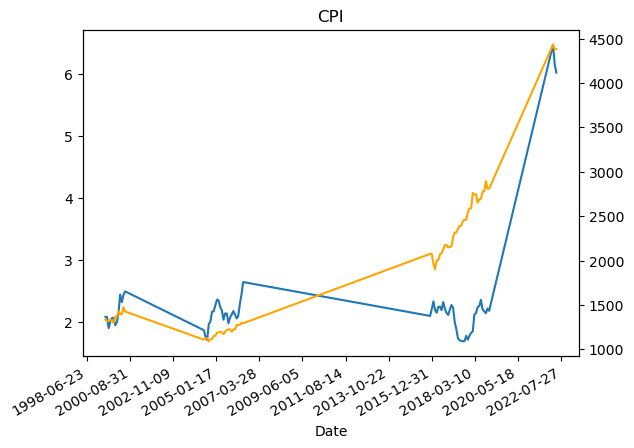

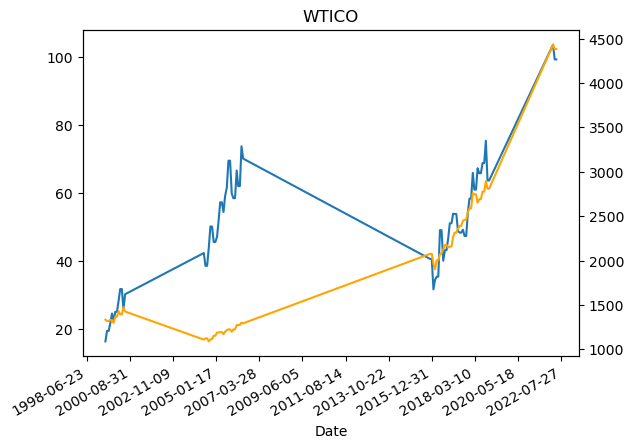

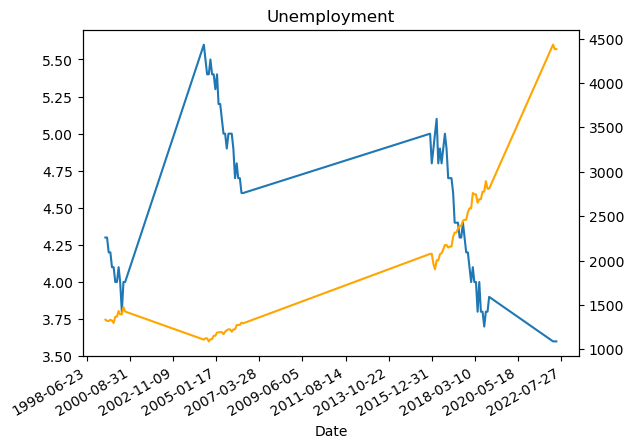

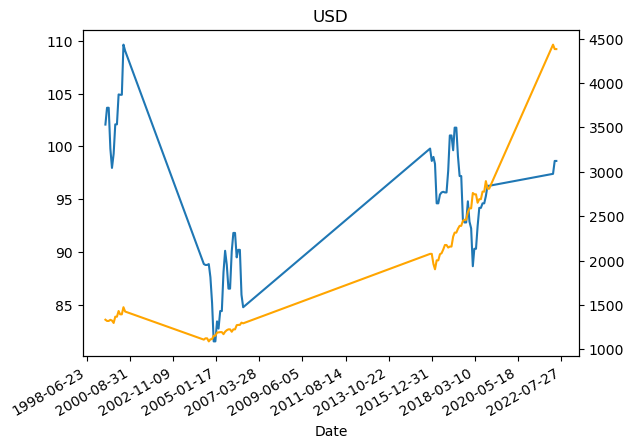

In [10]:
#Plot Dataset
List_Of_Variables = ['CPI', 'WTICO', 'Unemployment', 'USD']
for i in List_Of_Variables:
    first_axis = df_time_filtered[i].plot()
    first_axis.xaxis.set_major_locator(plt.MaxNLocator(15))
    second_axis = first_axis.twinx()
    second_axis.plot(df_time_filtered['sp500r30'], color='orange')
    second_axis.xaxis.set_major_locator(plt.MaxNLocator(15))
    plt.title(i)
    plt.show()

                   CPI  sp500r30     WTICO  Unemployment       USD
CPI           1.000000  0.583229  0.566166     -0.329831  0.120495
sp500r30      0.583229  1.000000  0.581349     -0.643944  0.263296
WTICO         0.566166  0.581349  1.000000     -0.208131 -0.405099
Unemployment -0.329831 -0.643944 -0.208131      1.000000 -0.574759
USD           0.120495  0.263296 -0.405099     -0.574759  1.000000


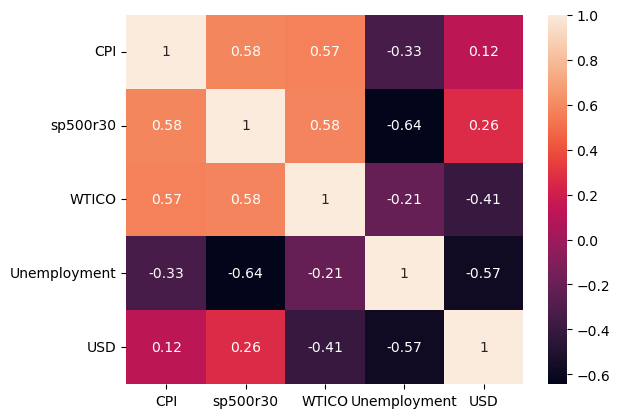

In [11]:
#Create a Heatmap
print(df_time_filtered.corr())
sns.heatmap(df_time_filtered.corr(), annot=True)
plt.show()

It seems like S&P 500 closed higher when CPI/Inflation numbers rose with high correlation of 0.9. WTI Crude Oil price and US Dollar index also showed a weak but positive correlation. Unemployment actually showed fairly strong negative correlation of -0.64. 

In [12]:
ind_var = pd.DataFrame(df_time_filtered, columns = ['CPI', 'WTICO', 'Unemployment', 'USD'])
dep_var = pd.DataFrame(df_time_filtered, columns = ['sp500r30'])

x = ind_var[['CPI', 'WTICO', 'Unemployment', 'USD']]
ind_var = sm.add_constant(ind_var)
y = dep_var['sp500r30']

regression_model = sm.OLS(y,x).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               sp500r30   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              391.9
Date:                Mon, 16 Jan 2023   Prob (F-statistic):                    5.71e-49
Time:                        14:08:02   Log-Likelihood:                         -585.29
No. Observations:                  78   AIC:                                      1179.
Df Residuals:                      74   BIC:                                      1188.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CPI            129.7531     81.988      1.583      0.118     -33.611     293.117
WTICO           23.1615      3.480      6.655      0.000      16.227      30.096
Unemployment  -511.1093     70.769     -7.222      0.000    -652.121    -370.098
USD             29.2975      3.789      7.732      0.000      21.747      36.848
==============================================================================
Omnibus:                       13.954   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                5.172
Skew:                          -0.351   Prob(JB):                       0.0753
Kurtosis:                       1.952   Cond. No.                         186.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\ijees\AppData\Local\Temp\ipykernel_19044\3898438784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_filtered['Prediction'] = pd.DataFrame(regression_model.predict(x))


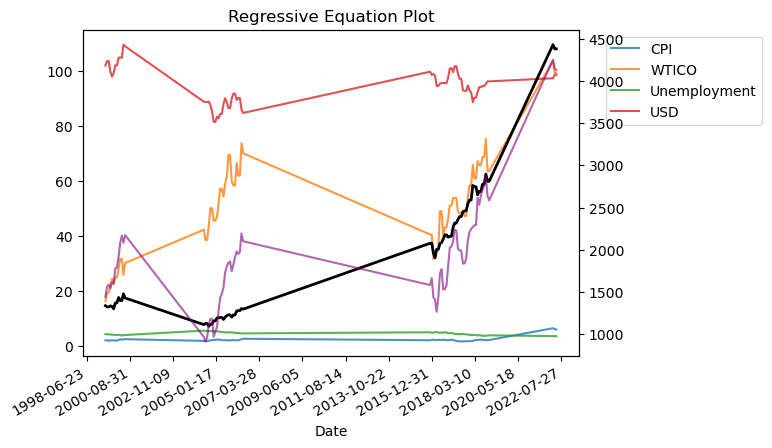

In [13]:
df_time_filtered['Prediction'] = pd.DataFrame(regression_model.predict(x))

first_axis = df_time_filtered['CPI'].plot(alpha = 0.8)
first_axis = df_time_filtered['WTICO'].plot(alpha = 0.8)
first_axis = df_time_filtered['Unemployment'].plot(alpha = 0.8)
first_axis = df_time_filtered['USD'].plot(alpha = 0.8)
first_axis.xaxis.set_major_locator(plt.MaxNLocator(15))

second_axis = first_axis.twinx()
second_axis.plot(df_time_filtered['sp500r30'], color='Black', linewidth=2, label='S&P500')
second_axis.plot(df_time_filtered['Prediction'], color='purple', alpha=0.6, label='Prediction')
second_axis.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title('Regressive Equation Plot')
first_axis.legend(bbox_to_anchor = (1.04,1), loc = "upper left")
plt.show()

**Conclusion.**
During the rising rate environment where Fed is raising interest rate, stock market tend to close the month higher than the preivous month. The exploration conducted did not reveal a clear relationship between inflation-related economic factors and the stock market during a rising rate environment. However, it is important to note that this study serves as a stepping stone for further exploration of historical data. Understanding the historical trends of the stock market can provide valuable insight into current market conditions and potential future developments. It is essential to continue to analyze historical data in order to gain a comprehensive understanding of the stock market and its relationship with inflation-related economic factors.

If you are curious about how the stock market performend during the rising rate environment, please check out my Tableau exploration:https://public.tableau.com/views/Capstone1_16607092350810/Story1?:language=en-US&:display_count=n&:origin=viz_share_link